In [1]:
# configura el notebook para que las celdas tomen todo el ancho de la pantalla
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Carga las librerías Necesarias

In [159]:
#!python -m spacy download es_core_news_sm
#!python -m spacy download es_core_news_md
import pandas as pd
import re
import math

# libreria que convertir texto en diccionarios
from collections import Counter

# librreias para la nube de palabras
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

# tamaño de palabras mas comunes
mas_comunes = 50

# libreria para graficos python
import matplotlib.pyplot as plt

# libreria para analisis númerico
from numpy import *
import numpy as np

# generador de matrix de palabras
from sklearn.feature_extraction.text import CountVectorizer

# para manejo de listas
import itertools

In [3]:
# libreria que trabaja con NLP
import spacy
#nlp_sm = spacy.load('es_core_news_sm')  # Assigns context-specific token vectors, POS tags, dependency parse and named entities. Supports identification of PER, LOC, ORG and MISC entities.
#nlp_md = spacy.load('es_core_news_md')  # 

import en_core_web_sm
nlp = en_core_web_sm.load()

# Funciones para procesamiento

In [4]:
# crea una nube de palabras que muestre las mas frecuentes
def cloud_word (texto,mas_comunes):
    
    for i in range(len(texto)):
        
        # Start with loading all necessary libraries
        cantidad_palabras = mas_comunes

        wordcloud = WordCloud(width=800, height=400, max_font_size=100, max_words=cantidad_palabras, background_color="white").generate(texto[i])
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

In [5]:
# divide los datos en cantidades permitidas por spacy
def fraccionar_informacion (texto):
    
    tamano_maximo = 1000000
    medida_texto  = math.ceil(len(texto)/tamano_maximo)
    limite_inferior = 0
    limite_superior = tamano_maximo
    
    lista_texto = [n for n in range(medida_texto)]

    # recorre las particiones permitidas
    for i in range(medida_texto):
        
        lista_texto[i] = texto[limite_inferior:limite_superior].replace("   "," ").replace("  "," ")
        
        limite_inferior += tamano_maximo
        limite_superior += tamano_maximo
    
    # devuelve la lista con loos textos fraccionados
    return lista_texto        

In [6]:
def lematizar_texto(lista_texto):
    
    listado_lemas = []
    for i in range(len(lista_texto)):

        doc = nlp(lista_texto[i])
        
        lemma_raw_text = [token.lemma_ for token in doc]
        
        # guarda los lemmas obtenidos
        listado_lemas += lemma_raw_text
    
    # retorna los lemas
    return listado_lemas

In [7]:
def mostrar_histograma (lista_texto, mas_comunes):
    
    for i in range (len(lista_texto)):

        plt.figure(figsize=(50,20) )
        graficar_texto = dict(lista_texto[i][0:mas_comunes])

        tamaño_letras = mas_comunes

        plt.bar(range(len(graficar_texto)), list(graficar_texto.values()), align='center')
        plt.xticks(range(len(graficar_texto)), list(graficar_texto.keys()) , rotation=90, fontsize=tamaño_letras)
        plt.yticks(fontsize=tamaño_letras)

        plt.show()

In [8]:
# crea el nuevo dataframe depurado
def procesamiento_dataframe (dataframe, depurar_frases):
    
    # carga solo la columna a evaluar    
    columnas_base = ['docid','dispute','complaint']

    # crea una lista de dataframes basado en el contenido de interes
    df_depurado   = pd.DataFrame(columns=columnas_base)
    
    for i in range(len(dataframe)):
        
        # elimina todos las frases clave, sensible al caso
        texto_completo = str(re.sub('|'.join(r'\b%s\b' % re.escape(s) for s in depurar_frases), "", dataframe['complaint'][i].lower())).lower()
        
        # elimina todos lo que no sea letras
        texto_depurado = re.sub('[^A-Za-z]+', ' ', texto_completo)
        
        # adiciona los registros al dataframe
        df_depurado = df_depurado.append([ pd.Series([i+1 , dataframe['dispute'][i], texto_depurado], index=df_depurado.columns )],ignore_index=True)
    
    # retorna el dataframe depurado
    return df_depurado

In [9]:
# convierte las palabras en matriz de frecuencias
def generar_matriz_valores (df, diccionario, columna_clave):

    vectorizer = CountVectorizer(vocabulary=diccionario, min_df=0, stop_words=frozenset(), token_pattern=r"(?u)\b\w+\b")
    X = vectorizer.fit_transform(df[columna_clave].values)
    matriz_de_valores = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names())
    
    return matriz_de_valores

In [10]:
# convierte la matriz de palabras en una lista de valores singulares
def descomposición_en_valores_singulares (lista_vectorizados):
    
    # lista de valores singulares
    svd = []
    
    # recorre la lista de vectores a crear los
    for i in range (len(lista_vectorizados)):
        
        # obtiene los valores de descomposición_en_valores_singulares
        matriz_ortogonales_m_x_n , valores_singulares, matriz_ortogonal_n_x_n = linalg.svd(lista_vectorizados[i])
    
        # crea una lista de la descomposición_en_valores_singulares
        svd.append([matriz_ortogonales_m_x_n , valores_singulares,  matriz_ortogonal_n_x_n])
    
    # retorna la lista de valores singulares
    return svd

In [11]:
# genera las matrices de temas
def crear_matrix_temas (lista_vectorizados):
    
    datos_finales = []
    
    for i in range(len(lista_vectorizados)):
        
        datos_finales.append([np.matrix(lista_vectorizados[i][0]) * np.matrix(lista_vectorizados[i][1])])
        
    return datos_finales

In [162]:
# crea la matriz con los resultados finales
def obtener_datos_matriz (matriz_de_valores_singulares_transpuestos, valores_vectorizados_transpuestos):
    
        # crea una lista de dataframes basado en el contenido de interes
    df_depurado   = pd.DataFrame(columns=list(valores_vectorizados.columns))        
        
    tamano = len(matriz_de_valores_singulares_transpuestos[0])
    
    for i in range (100):
        
        # crea una lista de listas
        dato = matriz_de_valores_singulares_transpuestos[0] * np.asmatrix(valores_vectorizados_transpuestos[i]).T
        
        # crea una sola lista
        dato = list(itertools.chain(*dato.tolist()))

        # adiciona los registros al dataframe
        df_depurado = df_depurado.append([ pd.Series(dato, index=df_depurado.columns )],ignore_index=True)       
        
    # retorna el dataframe final    
    return df_depurado 

# Carga los datos en dataframe

In [12]:
# carga la informacion en un dataframe
data_original = pd.read_excel("Data Consumer.xlsx")
stop_words    = pd.read_excel("stop_words.xlsx")

columnas_a_evaluar = ["complaint"]

columnas_base = list(data_original.columns)

# convierte las stop_words en lista para depurar los textos 
depurar_frases = ["xxxx"] + list(stop_words['Term'])
palabras_clave = ["lawyer","debt"]

# prepara los datos para la lematización

In [13]:
# guarda toda la informacion del texto sin procesar y ña convierte a minusculas
raw_text          = (" ".join(list(data_original['complaint']))).lower().replace("xxxx","").strip()

# elimina las stopwords
process_text = str(re.sub('|'.join(r'\b%s\b' % re.escape(s) for s in depurar_frases), '', raw_text)).strip()

## prepara la data raw y la lematiza

In [14]:
# convierte el texto en tokens
total_words_raw_text = raw_text.split(" ")

# obtiene las palabras mas usadas en el texto
frecuency_raw_text = Counter(total_words_raw_text).most_common(mas_comunes)

# fracciona el texto para ser procesado por el lematizador
fracciones_raw_text = fraccionar_informacion (raw_text)

# obtiene las frases lematizadas del texto
lemma_raw_text = lematizar_texto(fracciones_raw_text)

# obtiene una lista unica por si existen listas de listas
#lemma_raw_text = [item for sublist in lemma_raw_text for item in sublist]

# guarda la frecuencia de las palabras lematizadas
frecuency_lemma_raw_text = Counter(lemma_raw_text).most_common(mas_comunes)

## prepara la data sin stopwords y la lematiza

In [15]:
# convierte el texto en tokens
total_words_process_text = process_text.split(" ")

# obtiene las palabras mas usadas en el texto
frecuency_process_text = Counter(total_words_process_text).most_common(mas_comunes)

# fracciona el texto para ser procesado por el lematizador
fracciones_process_text = fraccionar_informacion (process_text)

# obtiene las frases lematizadas del texto
lemma_process_text = lematizar_texto(fracciones_process_text)

# guarda la frecuencia de las palabras lematizadas
frecuency_lemma_lemma_process_text = Counter(lemma_process_text).most_common(mas_comunes)

## prepara la data solo con carateres del alfabeto ingles y la lematiza

In [16]:
# elimina todos los caracteres que no sean letras
debug_text   = re.sub('[^A-Za-z]+', ' ', process_text).strip()

# convierte el texto en tokens
total_words_debug_text = debug_text.split(" ")

# obtiene las palabras mas usadas en el texto
frecuency_debug_text = Counter(total_words_debug_text).most_common(mas_comunes)

# fracciona el texto para ser procesado por el lematizador
fracciones_debug_text = fraccionar_informacion (debug_text)

# obtiene las frases lematizadas del texto
lemma_debug_text = lematizar_texto(fracciones_debug_text)

# obtiene una lista unica por si existen listas de listas
#lemma_debug_text = [item for sublist in lemma_debug_text for item in sublist]

# guarda la frecuencia de las palabras lematizadas
frecuency_lemma_debug_text = Counter(lemma_debug_text).most_common(mas_comunes)

# define los datos que se van a mostrar en las graficas

In [17]:
# guarda el tamaño de cada documento
total_data  = [["raw_text =",len(total_words_raw_text),len(raw_text),len(lemma_raw_text)],["process_text =",len(total_words_process_text), len(process_text),len(lemma_process_text)],["debug_text =",len(total_words_debug_text),len(debug_text),len(lemma_debug_text)]]
# guarda los textos a procesar originales
final_text  = [raw_text, process_text, debug_text]
# guarda los textos a procesar lematizados
final_lemma = [" ".join(lemma_raw_text), " ".join(lemma_process_text), " ".join(lemma_debug_text)]

# guarda los textos completos
lista_completos   = [frecuency_raw_text, frecuency_process_text, frecuency_debug_text]
# guarda las frases lematizadas a graficar
lista_lematizados = [frecuency_lemma_raw_text, frecuency_lemma_lemma_process_text, frecuency_lemma_debug_text]

# muestra las nubes de palabras de los textos

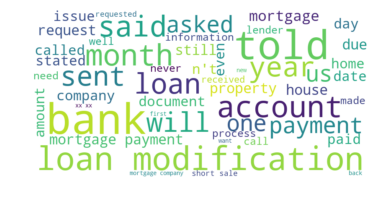

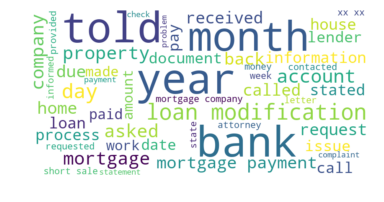

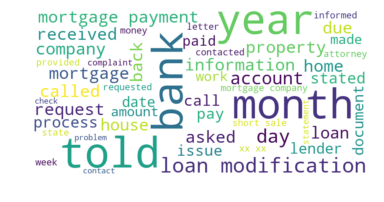

In [18]:
# crea las nubes de palabras con los datos creados originalmente
cloud_word(final_text, mas_comunes)

# muestra los histogramas de los textos

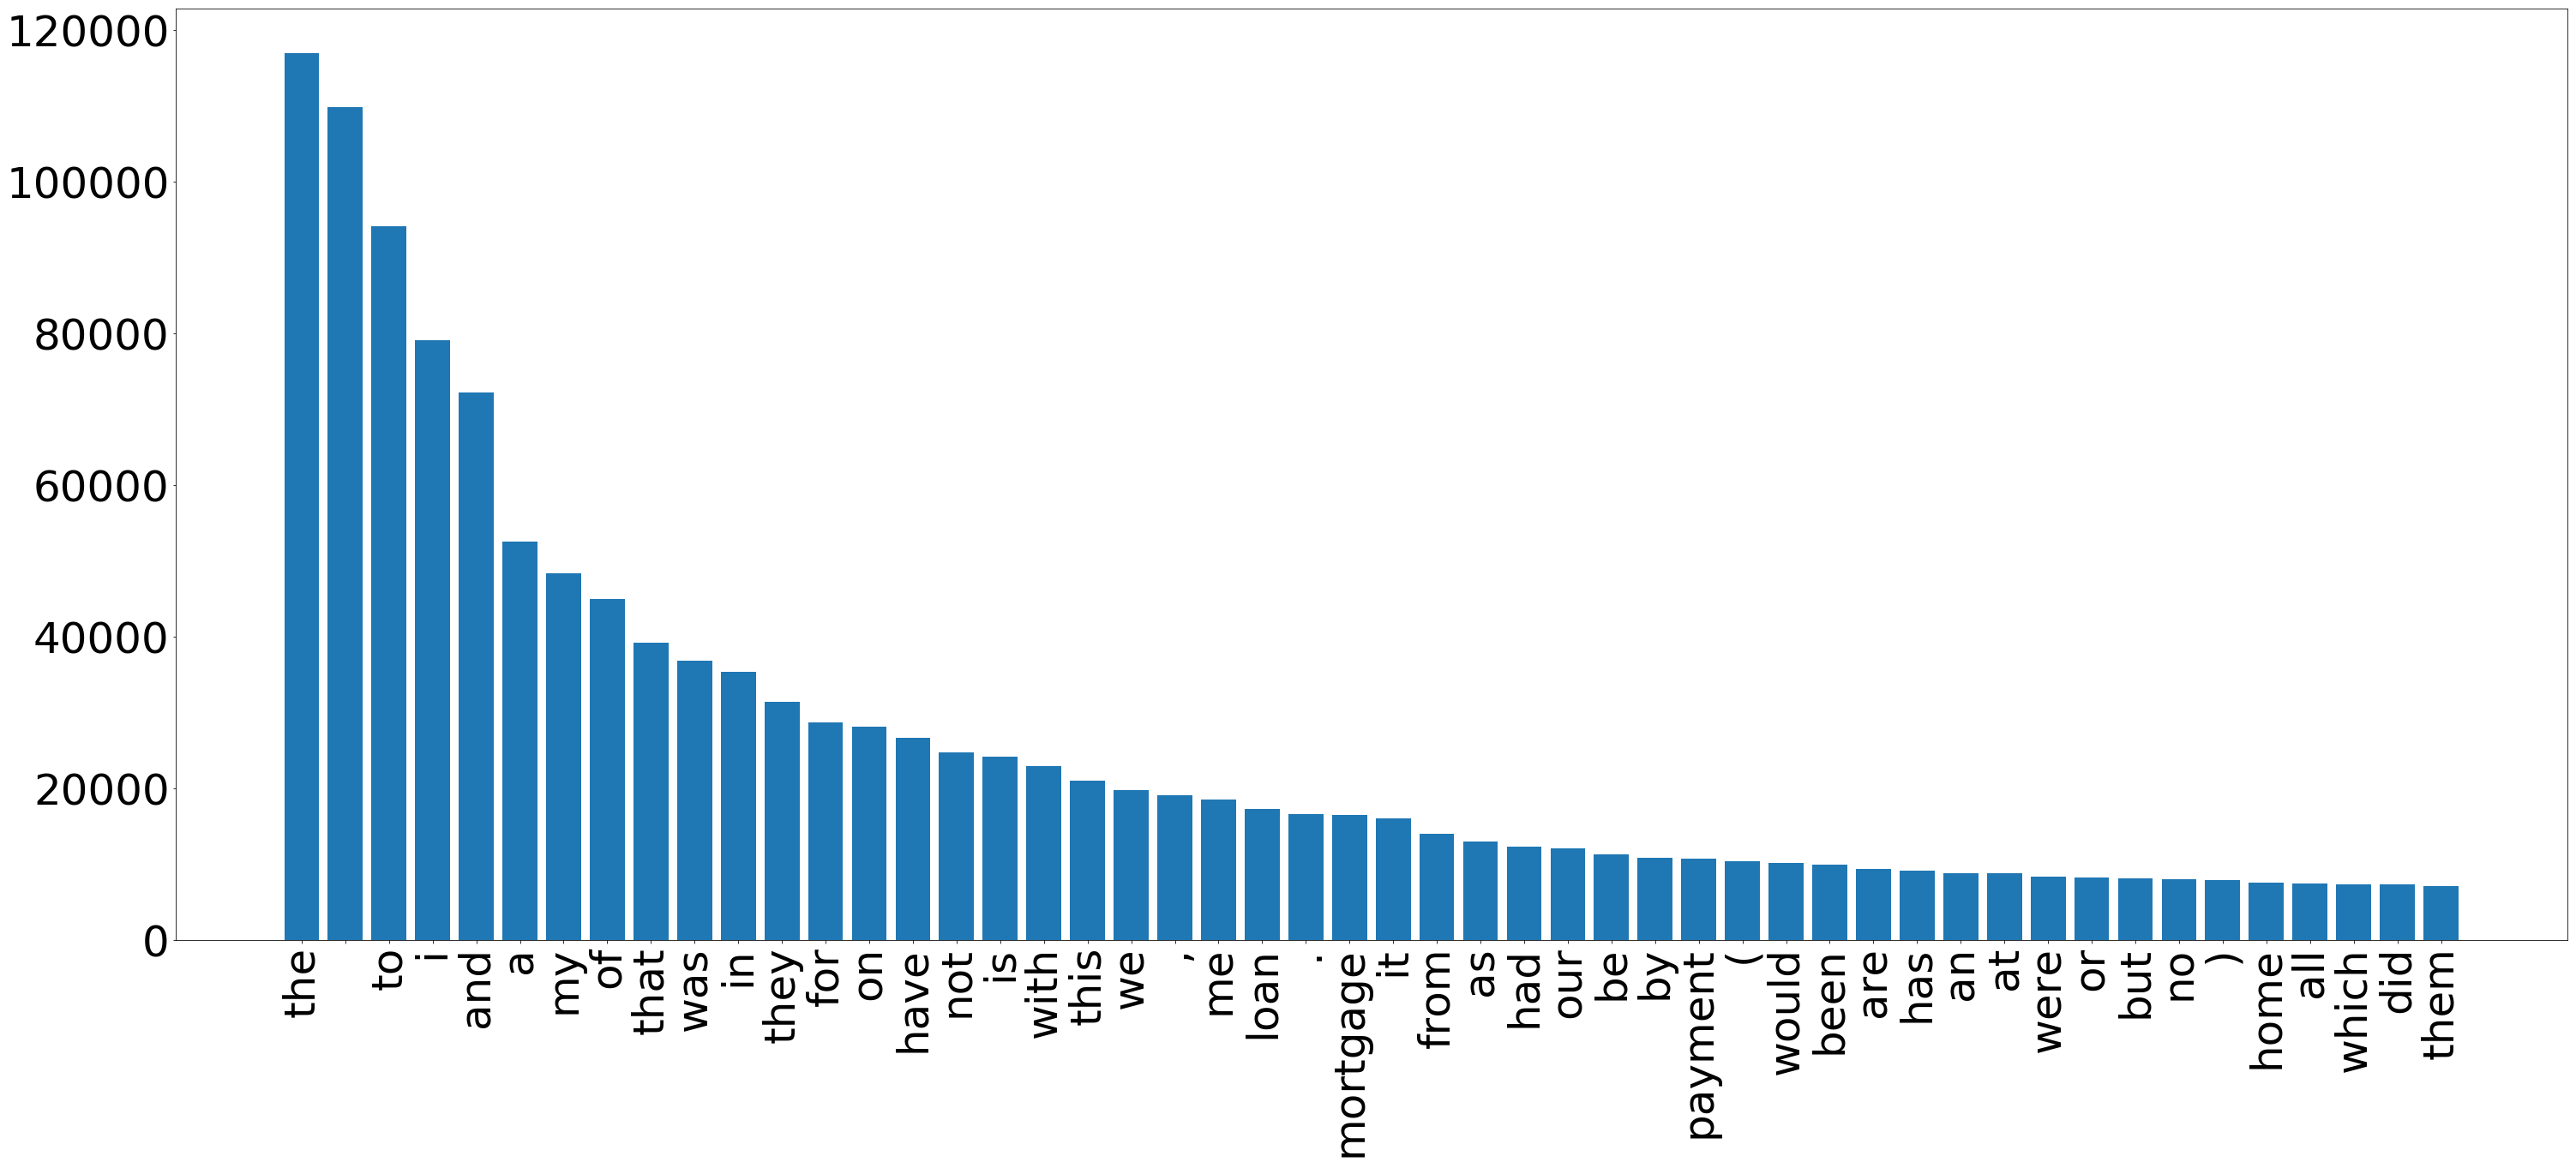

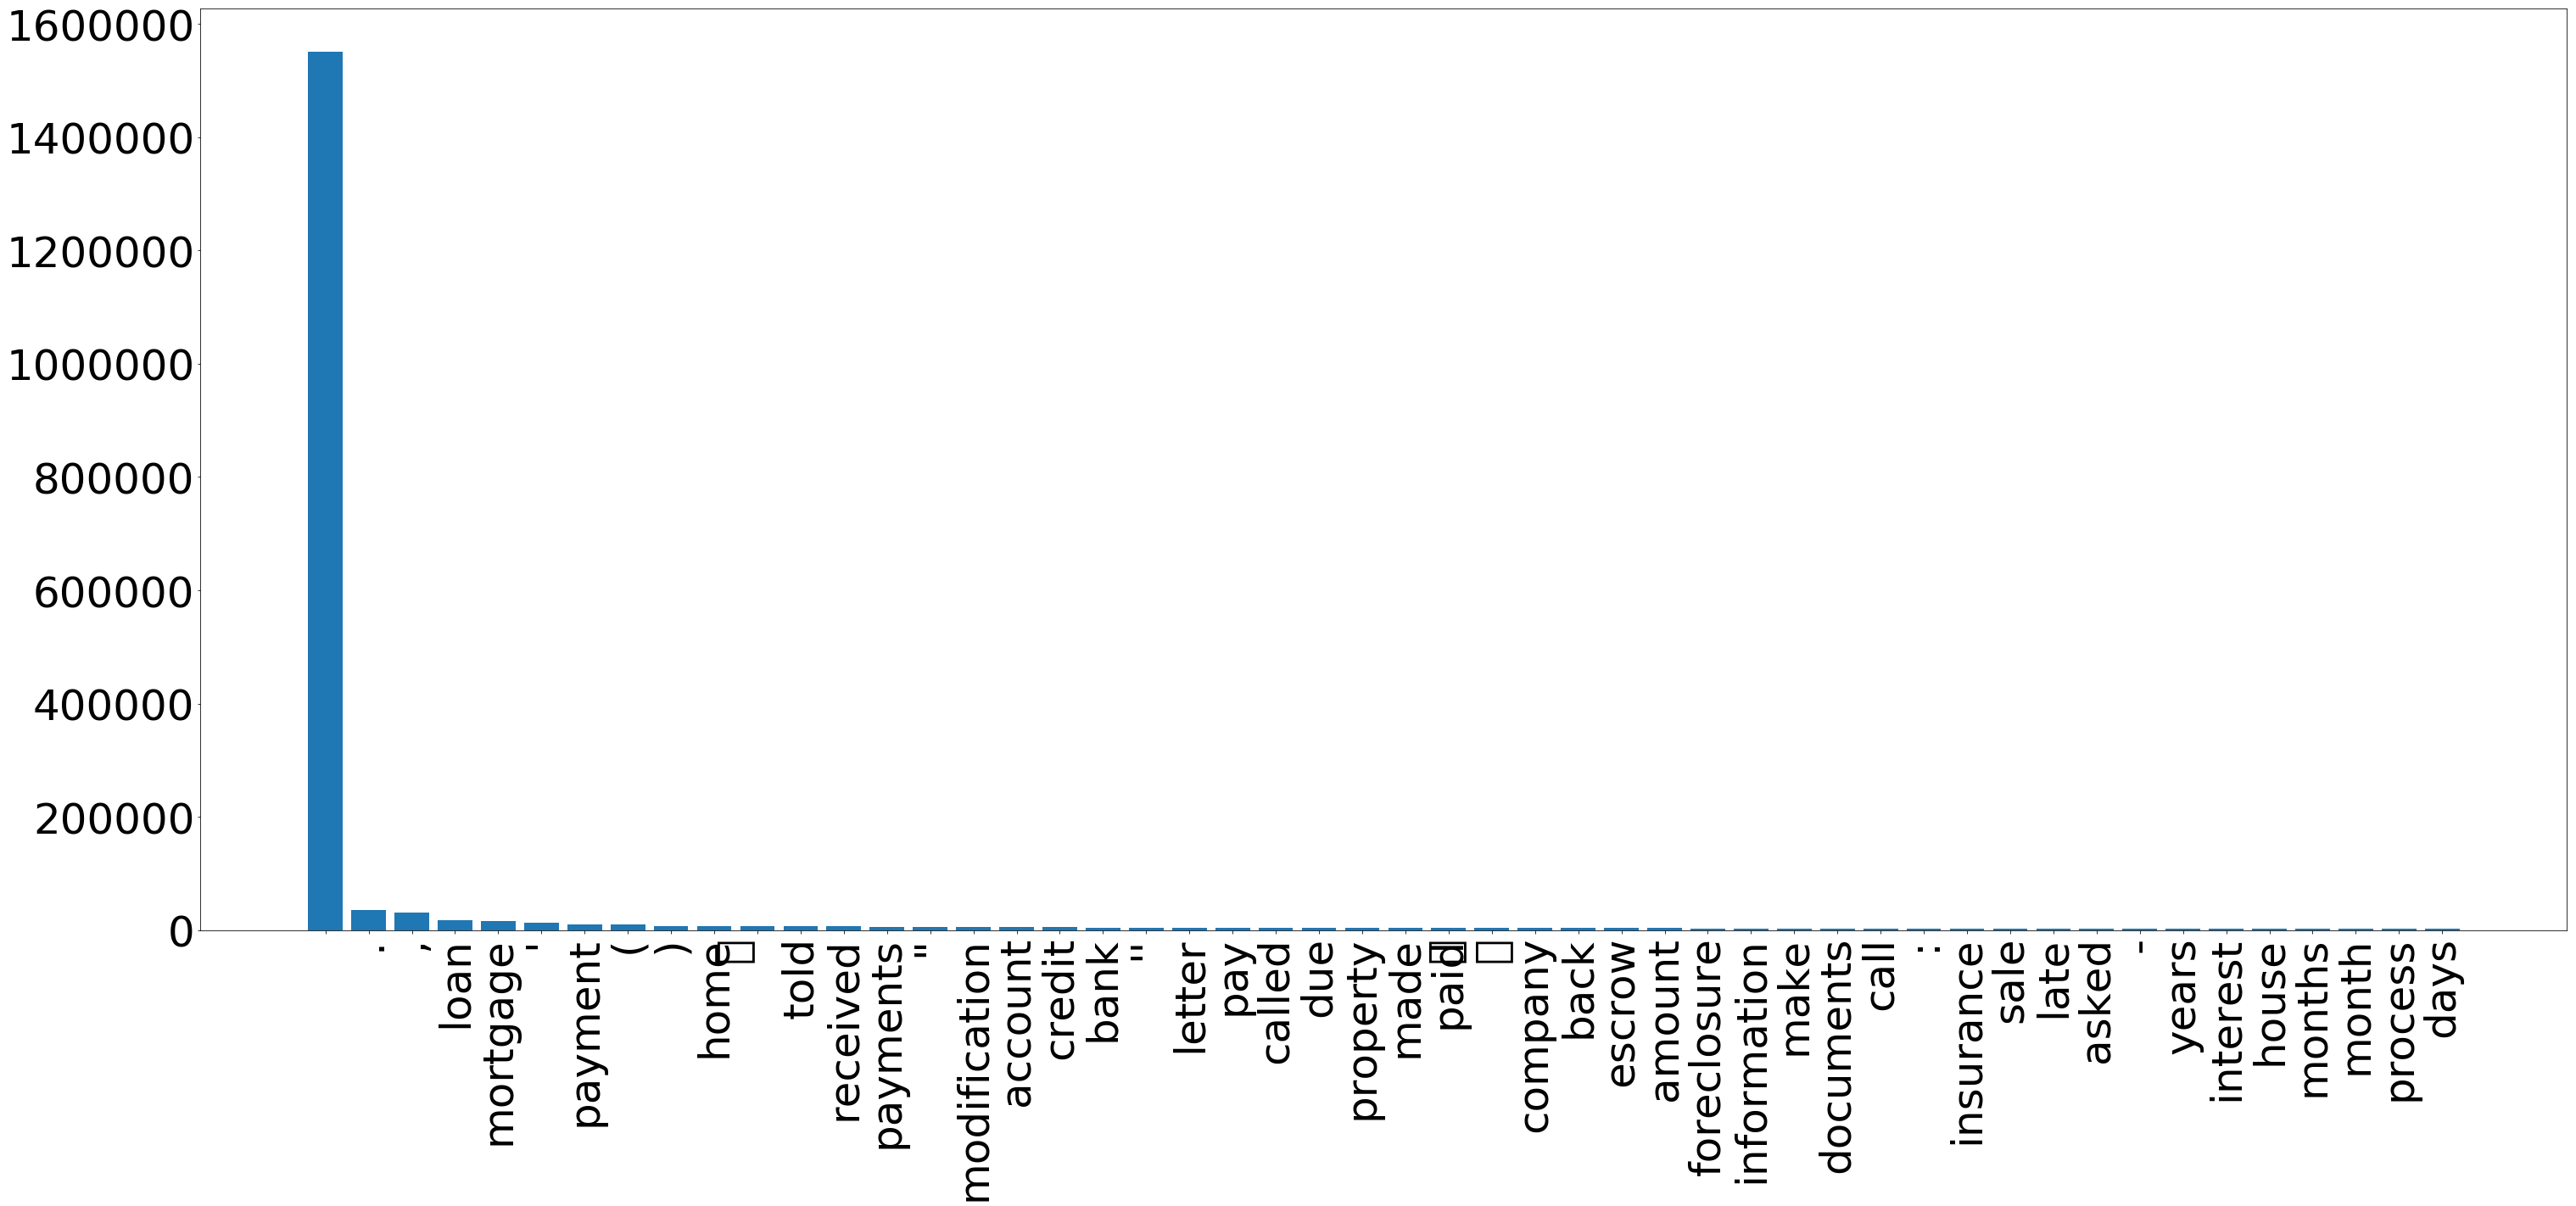

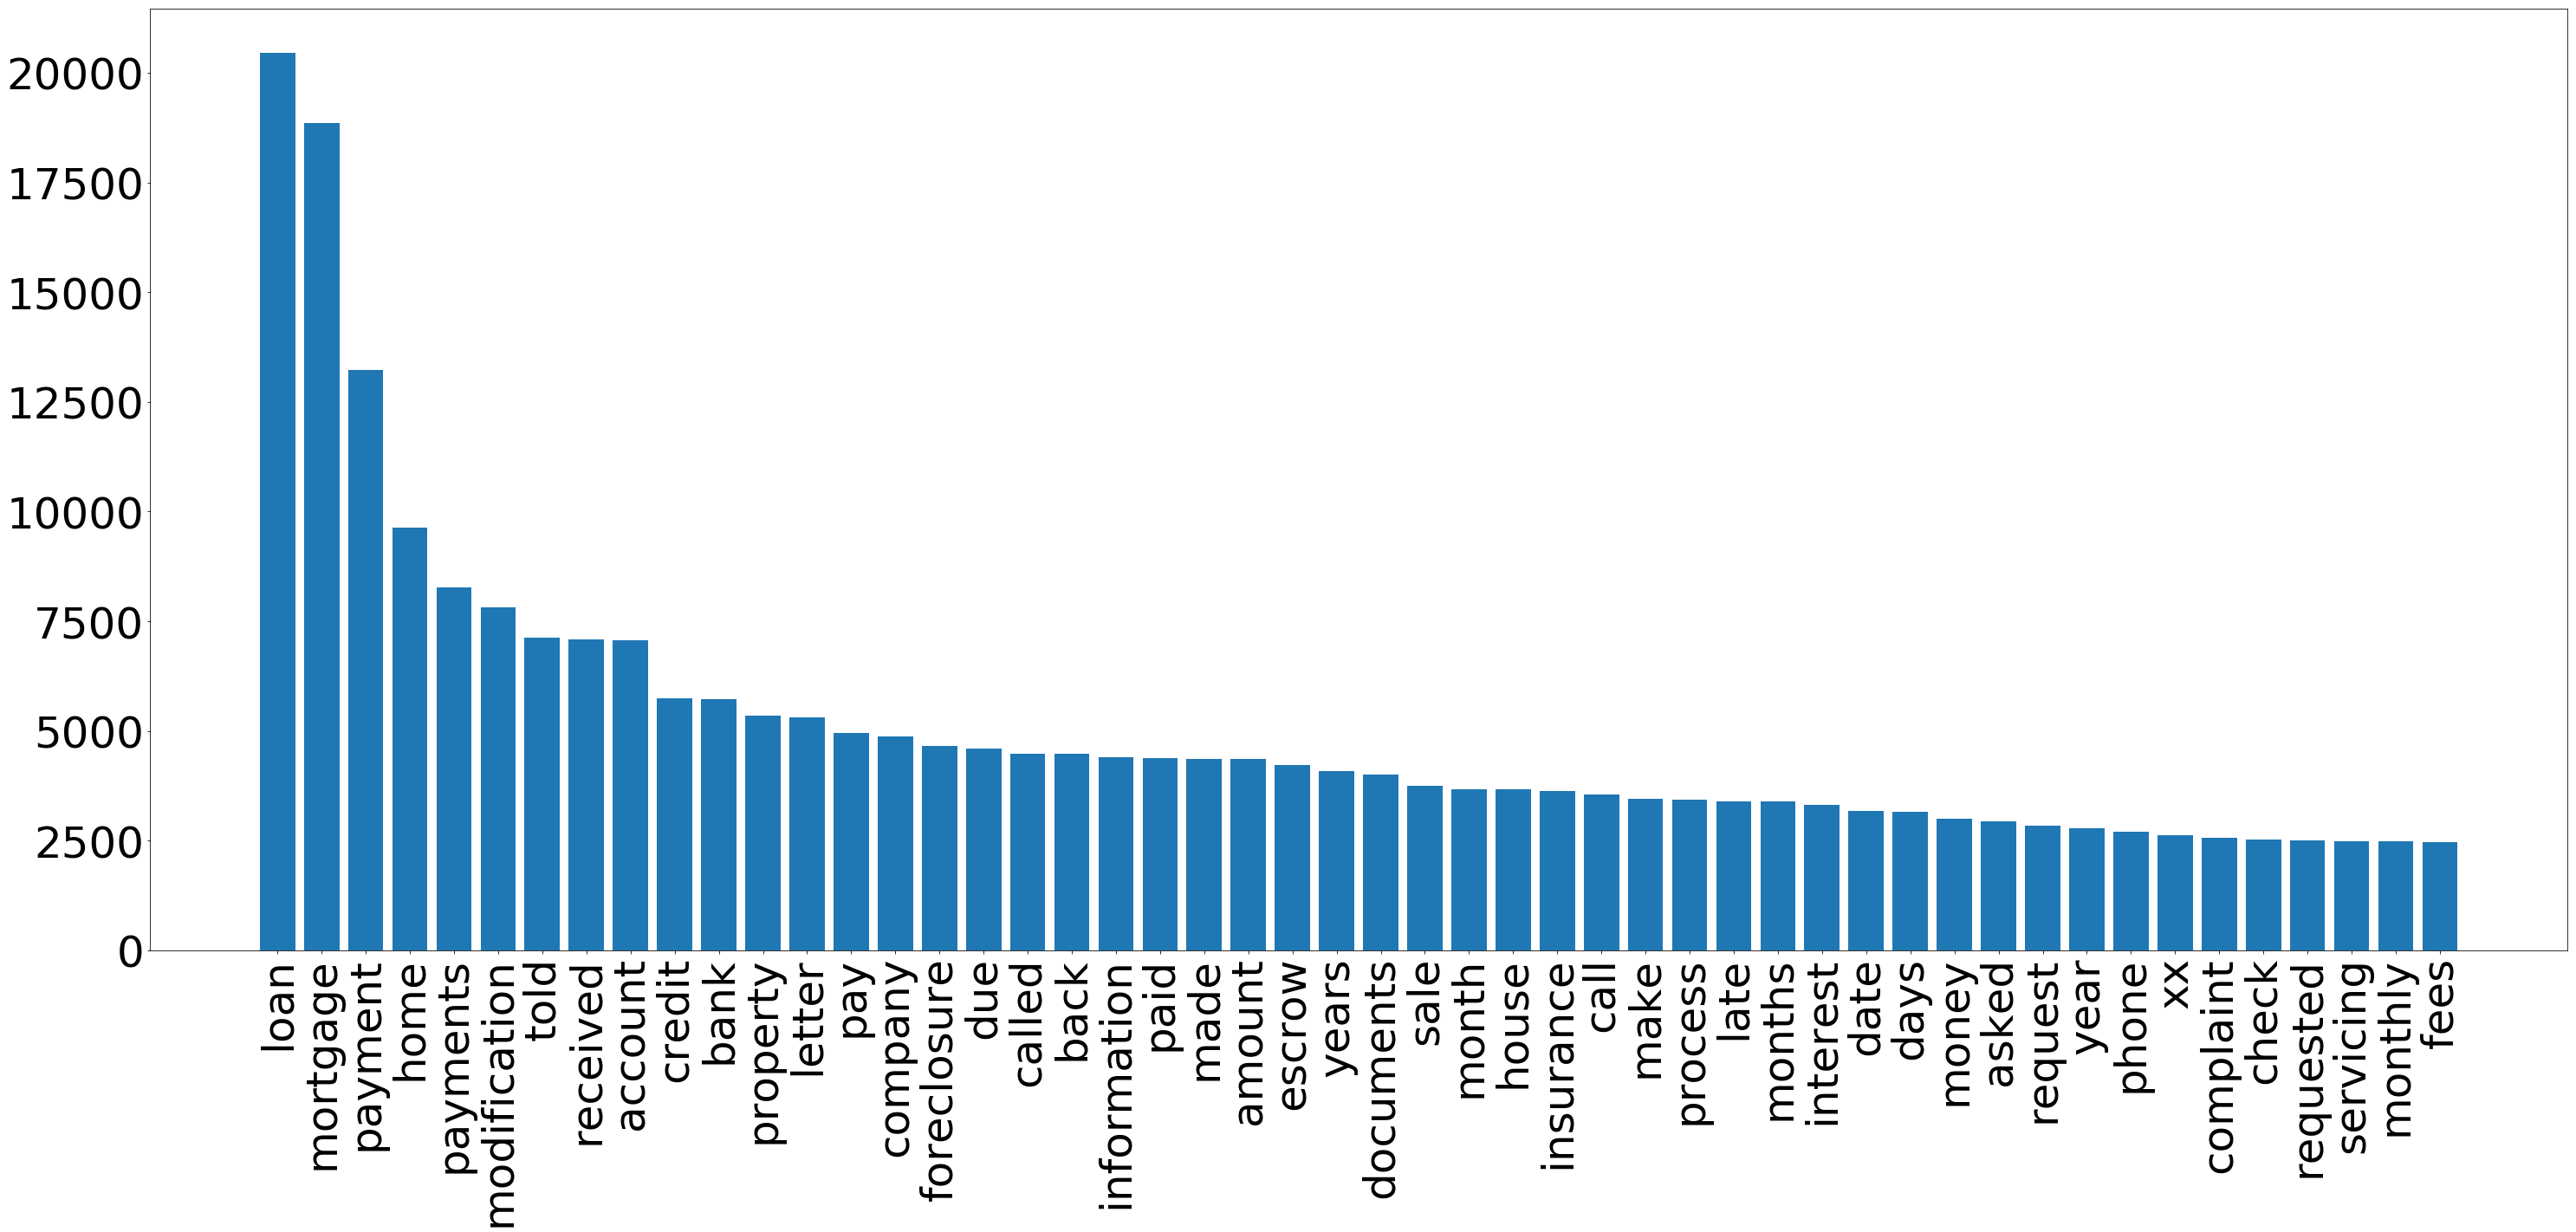

In [19]:
mostrar_histograma (lista_completos, mas_comunes)

# muestra las nubes de palabras de la lematización

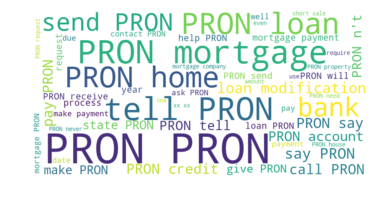

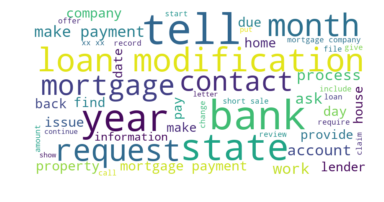

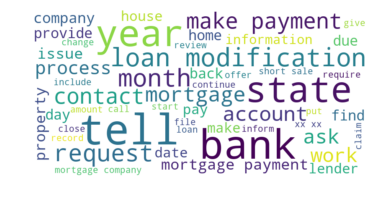

In [20]:
# crea las nubes de palabras con los datos creados lematizados
cloud_word(final_lemma, mas_comunes)

# muestra las histogramas de la lematización

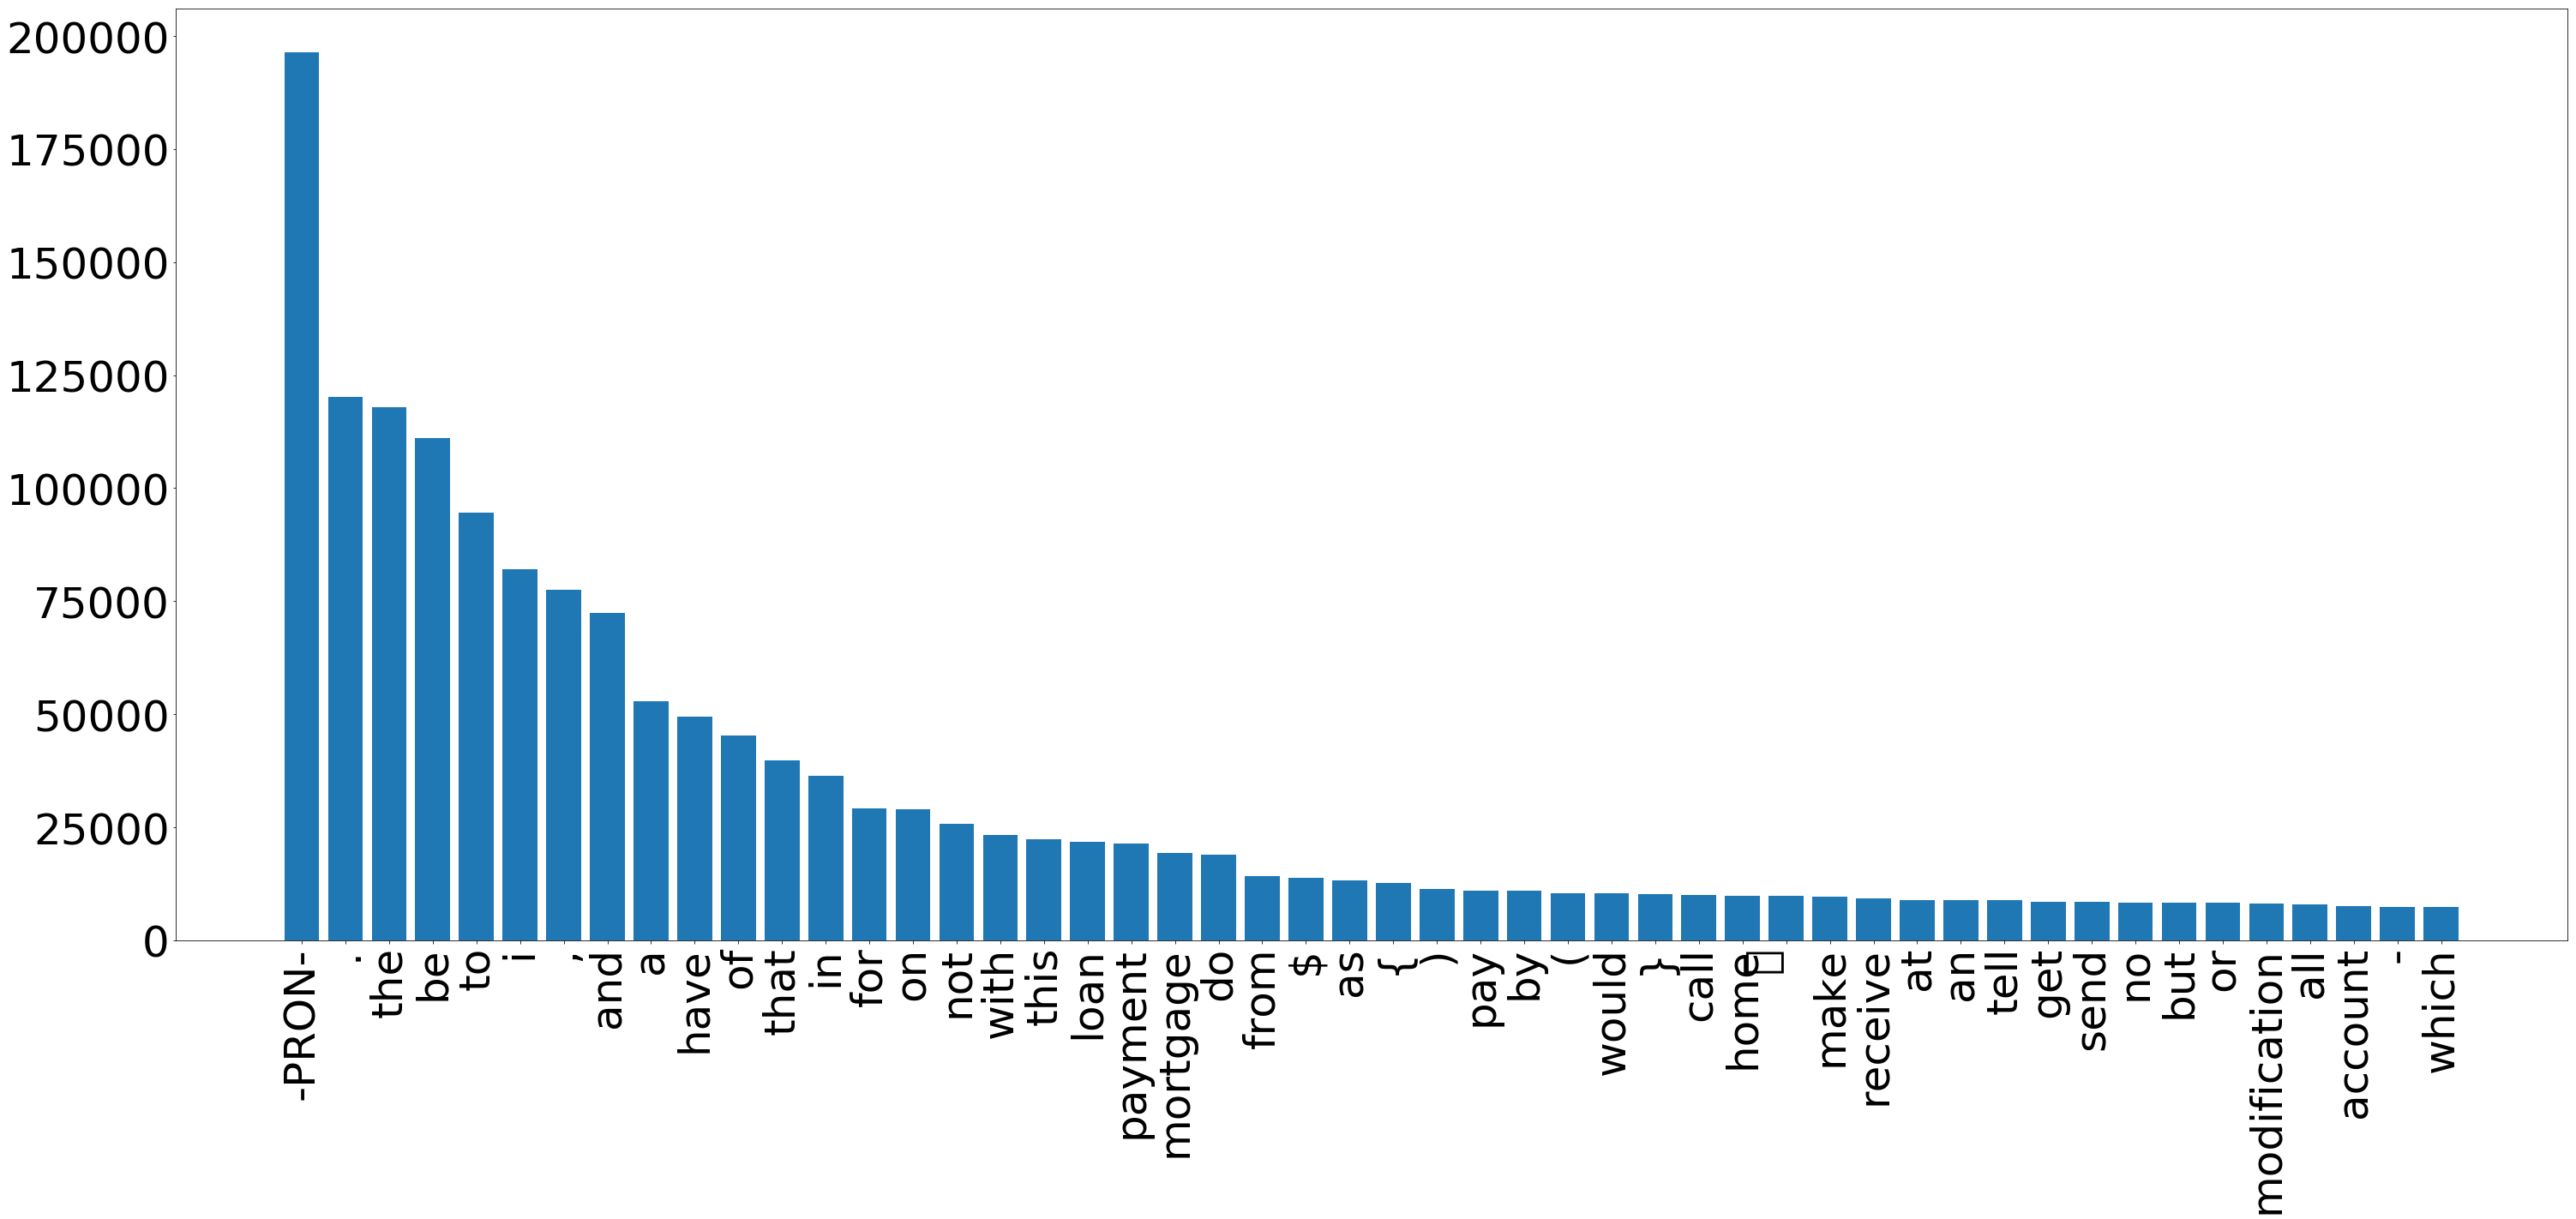

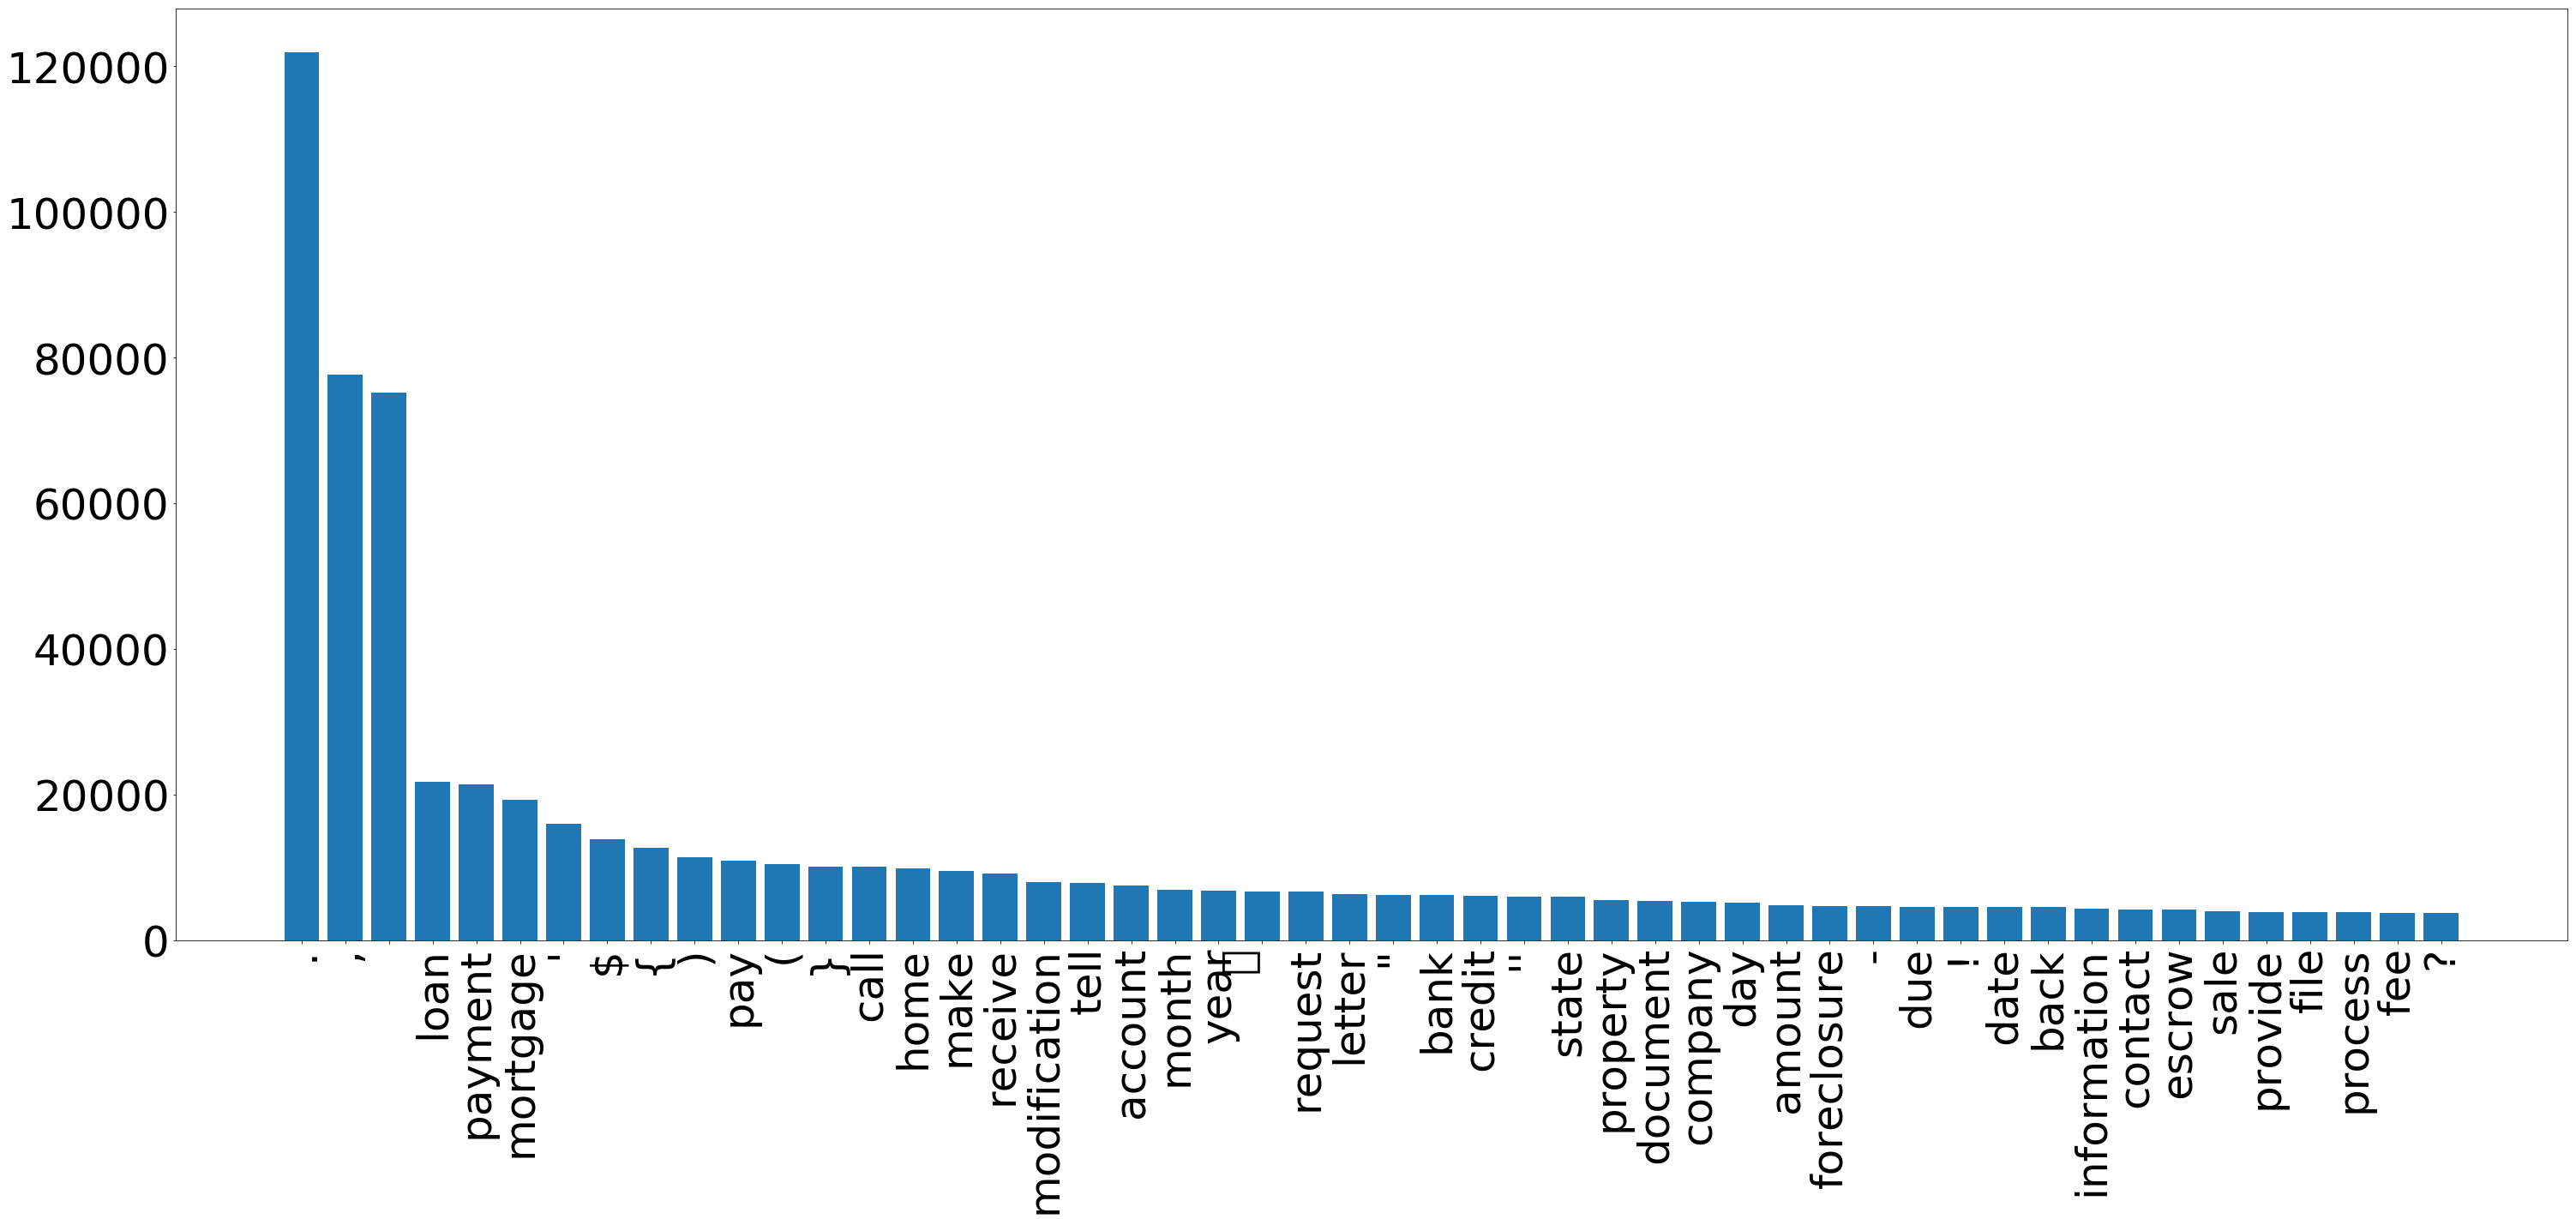

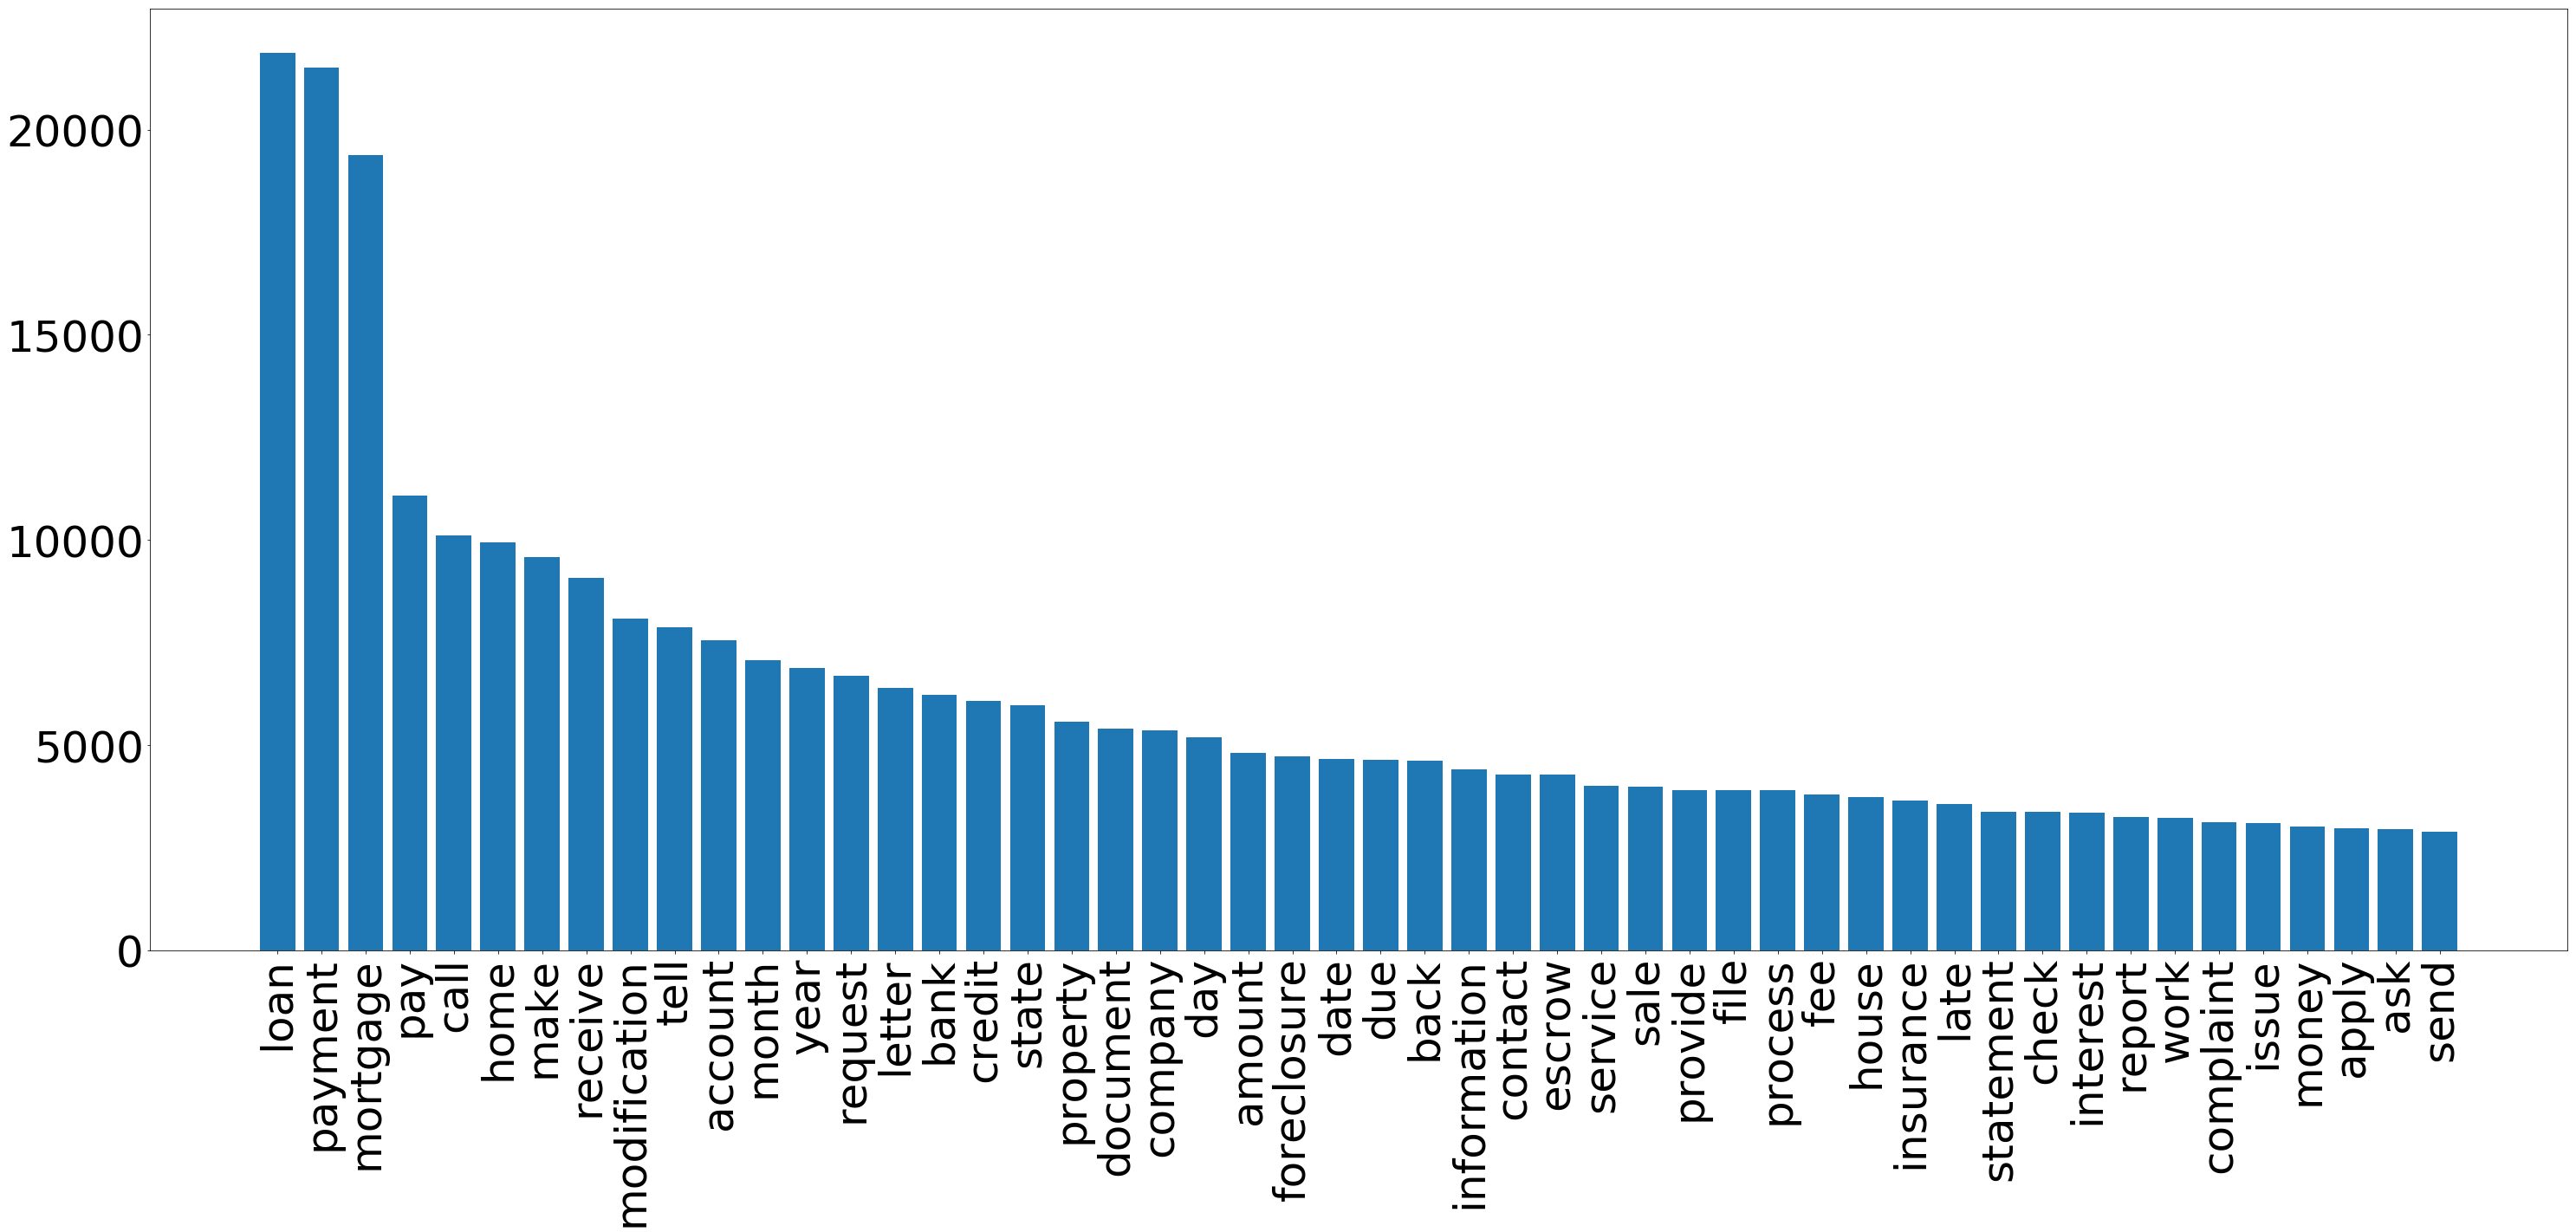

In [21]:
mostrar_histograma (lista_lematizados, mas_comunes)

# Creacion de matriz

In [22]:
# crea los dataframe donde se van a alojar los datos a trabajar
df_estudio    = procesamiento_dataframe (data_original, depurar_frases)
diccionario   = list(set(debug_text.split(" ")))
columna_clave = 'complaint'
# crea la matriz para procesar los valores
valores_vectorizados = generar_matriz_valores (df_estudio,diccionario, columna_clave)
matriz_de_valores    = valores_vectorizados.values
matriz_de_nombres    = valores_vectorizados.columns

valores_vectorizados_transpuestos = valores_vectorizados.T
matriz_de_valores_transpuestos    = valores_vectorizados_transpuestos.values
matriz_de_nombres_transpuestos    = valores_vectorizados_transpuestos.columns

# crea la lista que va a generar la descomposición_en_valores_singulares
lista_vectorizados = [valores_vectorizados, valores_vectorizados_transpuestos]

# Análisis Númerico

In [23]:
matriz_de_valores_singulares_normales , matriz_de_valores_singulares_transpuestos  = descomposición_en_valores_singulares (lista_vectorizados)

lista_vectorizados_calculados = [[matriz_de_valores_singulares_normales[0].T ,valores_vectorizados], [matriz_de_valores_singulares_transpuestos[0].T ,valores_vectorizados_transpuestos]]

# Matriz de temas

In [24]:
matrix_temas = crear_matrix_temas(lista_vectorizados_calculados)

In [163]:
matriz_final = obtener_datos_matriz (matriz_de_valores_singulares_transpuestos, valores_vectorizados_transpuestos)

In [164]:
matrix_temas

[[matrix([[-1.14939478e-02, -3.99007691e-02, -2.89710777e-02, ...,
           -7.26146031e-03, -4.86448045e-02, -7.28235322e-01],
          [-4.39215030e-03, -1.27942054e-02,  1.94327059e-02, ...,
            2.27018537e-03, -7.32257150e-03, -8.99107477e-02],
          [-8.70621547e-04, -3.32665558e-02,  7.77145445e-03, ...,
            3.46023548e-03,  1.24517191e-02, -6.26092173e-02],
          ...,
          [ 3.10567169e-06,  2.51402096e-05, -1.86414028e-05, ...,
           -4.61536222e-05,  8.80470251e-06,  2.46305720e-06],
          [-4.97009785e-06,  3.49976437e-05,  2.16584594e-05, ...,
           -2.22820024e-06, -5.83758422e-07, -1.32843043e-05],
          [ 3.47769243e-18,  7.64694304e-18,  1.06658888e-17, ...,
           -1.19080173e-18,  3.02144742e-17, -1.00060238e-16]])],
 [matrix([[-6.83223287e-01, -2.19125950e+00, -1.41062183e+01, ...,
           -3.24723005e+00, -1.03028853e+01, -1.56980139e+00],
          [-2.47494466e-01,  4.24537092e-01, -1.00198065e+01, ...,
     

In [165]:
matriz_final

,pap,assistence,travelled,aggragate,surmise,classified,didreceive,scandal,comprise,pleading,...,untruths,investors,propoerly,abysmal,predatoryloan,somwe,attny,simplicity,lasting,unfairly
0,-1.993582,0.108595,-0.021173,0.028785,-0.113387,0.021181,-0.029126,0.082469,0.092342,-0.035875,...,0.007573,0.022961,-0.013692,-0.010326,0.004787,0.009776,-0.054827,-0.013168,0.011902,-0.002846
1,-0.025827,-2.602956,-0.010954,-0.130956,0.001157,0.026828,0.192844,0.115979,-0.008789,-0.039863,...,0.000942,0.011578,-0.007478,0.031280,0.008258,0.000589,0.022822,-0.027339,0.007859,-0.003816
2,0.037370,-1.637601,-13.225284,-0.504322,0.432630,0.248595,-0.112128,0.001948,0.185197,-0.214983,...,0.196396,-0.034463,0.136517,0.236955,0.154244,-0.000043,-0.528925,0.311772,0.437598,0.343215
3,-0.266232,-1.583778,-1.199193,-8.417658,0.019722,0.332700,-0.148264,0.017107,0.952931,-0.206920,...,-0.152769,0.208369,-0.052149,-0.006167,0.019740,-0.011319,-0.068007,0.046192,-0.039149,-0.016553
4,-0.442074,-0.099374,0.017800,0.051985,-2.644153,-0.010778,0.050428,-0.008559,-0.000458,-0.062062,...,-0.029025,-0.068976,-0.022216,0.026736,0.015902,-0.014139,0.089805,0.012625,0.098911,0.017472
5,-0.308890,-1.958307,-0.601539,-2.986600,-2.024635,-0.434804,0.120397,-0.102603,0.796996,-0.149408,...,-0.195952,-0.045911,-0.089258,0.109178,0.015060,-0.003434,0.077732,0.014023,0.004437,0.166608
6,-0.012630,-0.140660,-0.178433,-0.554199,0.025563,0.033791,-2.323400,0.033346,0.159371,-0.087697,...,-0.001770,-0.009786,0.003607,0.014864,0.014714,0.008320,0.017892,-0.007005,-0.013440,0.012916
7,0.031578,0.023489,-0.042575,-0.033610,-0.014532,0.046656,-0.196271,-0.170922,-0.082609,-0.047011,...,0.023869,0.064401,-0.012307,0.012649,-0.006112,0.001079,-0.016449,0.004739,0.000614,0.026050
8,-0.373044,-2.284014,-0.949188,-1.312415,-0.416942,0.100742,-0.135041,-0.049044,-11.370416,-0.220326,...,0.257958,-0.099098,-0.097497,-0.043461,0.036327,0.011601,0.033207,0.026439,-0.055045,0.016314
9,-0.086328,-0.519900,-1.827672,-1.573815,-0.053882,-0.030178,0.058289,0.005001,0.368495,-0.522233,...,-0.020282,-0.020834,-0.014228,0.063984,0.015053,-0.020972,-0.003259,0.057355,0.050497,0.011608
